In [1]:
!pip install tf-nightly-2.0-preview

     |████████████████████████████████| 88.5MB 1.6MB/s 
     |████████████████████████████████| 450kB 31.6MB/s 
     |████████████████████████████████| 61kB 21.5MB/s 
     |████████████████████████████████| 4.1MB 29.4MB/s 
  Created wheel for opt-einsum: filename=opt_einsum-2.3.2-cp36-none-any.whl size=49882 sha256=8ae2a1fc8e8a1a517f027ea56669c91e52544f17c818cf6d5684e0e1058ae7db
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20190813


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)



W0814 03:28:01.039998 140680503269248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


W0814 03:28:29.625219 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:28:29.679258 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:28:29.688841 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:28:29.697018 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:28:29.705166 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:28:29.713389 140680503269248 training_utils.py:1210] When passing input data as arrays

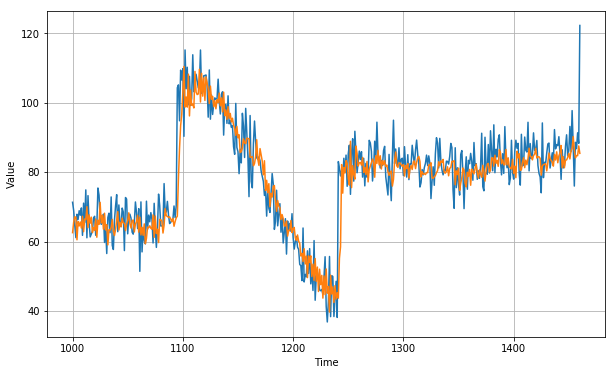

In [6]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1106935

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

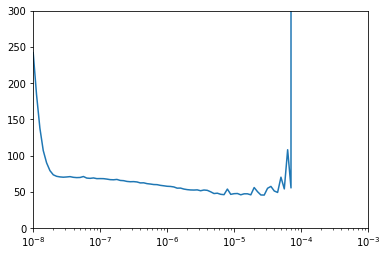

In [9]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 20
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

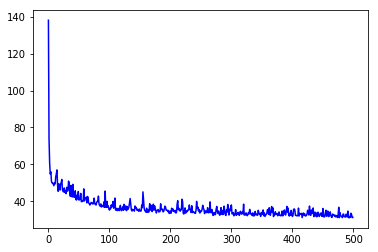

In [17]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[49.9365204534223, 49.39846044971097, 53.261821131552416, 54.87741697988203, 56.996528748543035, 48.68165760655557, 45.40884264053837, 49.472438443091605, 47.56046190569478, 46.04519844055176, 49.279737164897305, 50.262070748113814, 51.80321970293599, 46.22327718427104, 45.3714609453755, 45.04715328831826, 47.20292634348716, 44.799342124692856, 45.38105330928679, 44.11159872239636, 47.586673736572266, 45.485075058475616, 45.71846734323809, 50.919012008174775, 49.790517068678334, 44.72385517243416, 42.679771669449345, 48.610575522145915, 46.57865013614778, 42.293731935562626, 49.18121344043362, 43.34139657789661, 42.14234899705456, 42.228538513183594, 45.68061170270366, 40.96943639939831, 40.66725355579007, 43.31407953077747, 41.27638804528021, 45.28909769365865, 40.66641229198825, 40.785205656482326, 41.18386939264113, 44.25250957858178, 39.75707281789472, 40.128705978393555, 39.85504021183137, 40.19924520677136, 46.71439146226452, 40.13993743158156, 41.775706260435044, 41.857385389266

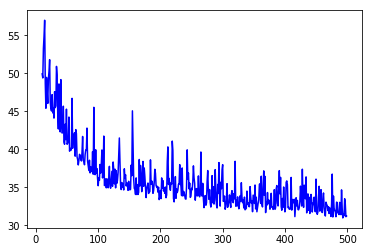

In [18]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

W0814 03:54:13.344073 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:54:13.392565 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:54:13.403229 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:54:13.412321 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:54:13.421394 140680503269248 training_utils.py:1210] When passing input data as arrays, do not specify `steps_per_epoch`/`steps` argument. Please use `batch_size` instead.
W0814 03:54:13.430811 140680503269248 training_utils.py:1210] When passing input data as arrays

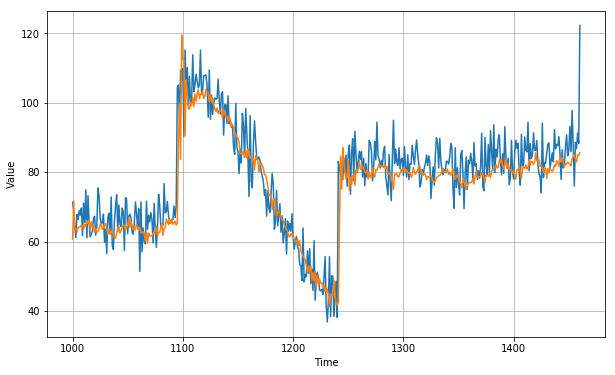

In [19]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1102905